Resnet18, MobileNet-v1, custom_model 구현

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import random
import matplotlib.pyplot as plt

In [2]:
seed = 2024
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
cudnn.deterministic = True
cudnn.benchmark = False

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device is {device}')

device is cuda


In [3]:
# Data Aumgentation - Train Data
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset = datasets.CIFAR10(root='./data', train=True,
                                 download=True,
                                 transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False,
                                download=True,
                                transform=transform_test)

100%|██████████| 170M/170M [00:05<00:00, 31.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [5]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=2)

# classes = ('plane', 'car', 'bird', 'cat', 'deer',
#            'dog', 'frog', 'horse', 'ship', 'truck')

In [6]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, 10)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [7]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [8]:
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [9]:
model_resnet = ResNet18().to(device)
num_epochs = 200
learning_rate = 0.1
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_resnet.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4) # L2 regularization 적용
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    total = 0
    correct = 0
    train_loss = 0.0

    # train
    model_resnet.train()
    print(f'   Epoch [{epoch+1}/{num_epochs}]')
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = 100. * correct / total

    # validation
    model_resnet.eval()
    val_loss = 0.0
    val_total = 0
    val_correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_resnet(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100. * val_correct / val_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)


    print(f'Train Loss: {train_loss:.4f}')
    print(f'  Val_Loss: {val_loss:.4f}')
    print(f' Train_acc: {train_accuracy:.2f}%')
    print(f'   Val_acc: {val_accuracy:.2f}%\n')

    scheduler.step()

   Epoch [1/200]
Train Loss: 2.1658
  Val_Loss: 1.7820
 Train_acc: 24.69%
   Val_acc: 32.08%

   Epoch [2/200]
Train Loss: 1.6387
  Val_Loss: 1.5338
 Train_acc: 39.14%
   Val_acc: 43.44%

   Epoch [3/200]
Train Loss: 1.4524
  Val_Loss: 1.3542
 Train_acc: 46.65%
   Val_acc: 50.92%

   Epoch [4/200]
Train Loss: 1.3088
  Val_Loss: 1.2307
 Train_acc: 52.47%
   Val_acc: 56.09%

   Epoch [5/200]
Train Loss: 1.1526
  Val_Loss: 1.1262
 Train_acc: 58.66%
   Val_acc: 59.01%

   Epoch [6/200]
Train Loss: 1.0193
  Val_Loss: 0.9828
 Train_acc: 63.85%
   Val_acc: 65.79%

   Epoch [7/200]
Train Loss: 0.9036
  Val_Loss: 1.0309
 Train_acc: 68.17%
   Val_acc: 63.68%

   Epoch [8/200]
Train Loss: 0.8033
  Val_Loss: 0.9497
 Train_acc: 71.83%
   Val_acc: 68.03%

   Epoch [9/200]
Train Loss: 0.7148
  Val_Loss: 0.8210
 Train_acc: 74.81%
   Val_acc: 71.85%

   Epoch [10/200]
Train Loss: 0.6415
  Val_Loss: 0.7680
 Train_acc: 77.81%
   Val_acc: 73.61%

   Epoch [11/200]
Train Loss: 0.6021
  Val_Loss: 0.6682
 Tr

In [ ]:
# test
correct = 0
test_loss = 0
model_resnet.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_resnet(images)
        loss = criterion(outputs, labels)

        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        test_loss += loss.item()

test_acc_resnet = 100.* correct / len(test_loader.dataset)
print(f'Test Accuracy: {test_acc_resnet:.2f} %')

test_loss_resnet = test_loss / len(test_loader)
print(f'Test Loss: {test_loss_resnet:.4f}')

Test Accuracy: 94.70 %
Test Loss: 0.2029


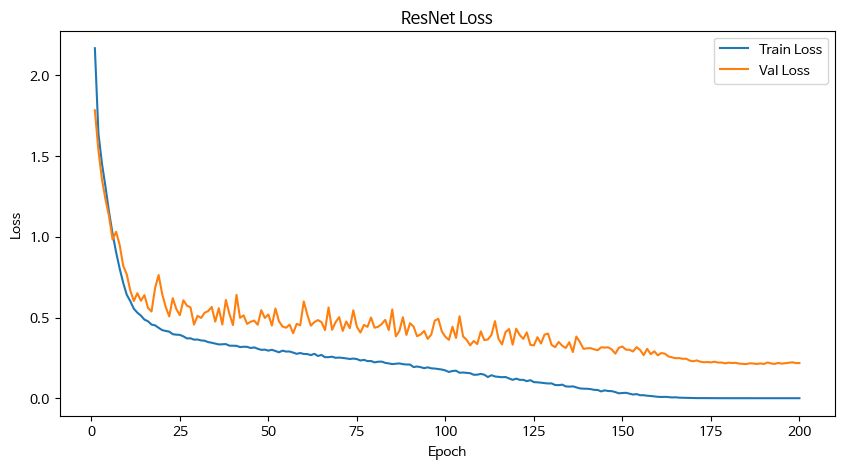

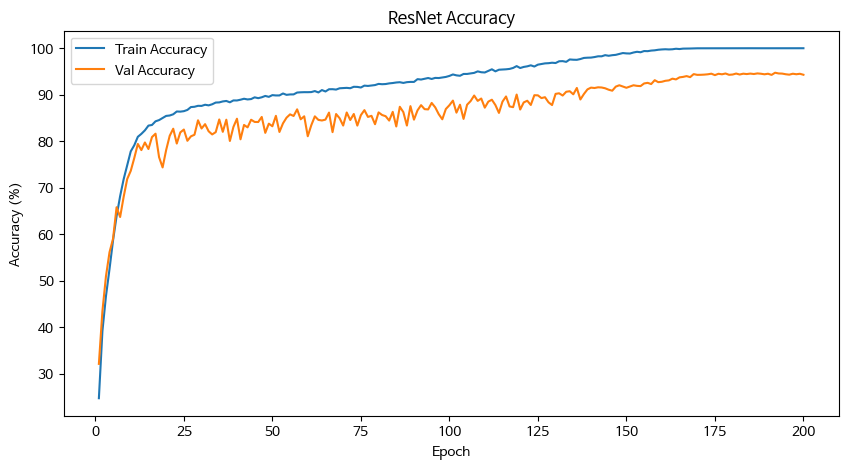

In [ ]:
# Loss graph
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ResNet Loss')
plt.legend()
plt.show()

# Accuracy graph
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('ResNet Accuracy')
plt.legend()
plt.show()

In [10]:
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [11]:
class Block(nn.Module):
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, in_planes,
                               kernel_size=3, stride=stride, padding=1,
                               groups=in_planes, bias=False)
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv2 = nn.Conv2d(in_planes, out_planes,
                               kernel_size=1, stride=1, padding=0,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out

In [12]:
class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    cfg = [64, (128, 2), 128, (256, 2), 256, (512, 2), 512, 512, 512, 512, 512, (1024, 2), 1024]

    def __init__(self):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32)
        self.linear = nn.Linear(1024, 10)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            out_planes = x if isinstance(x, int) else x[0]
            stride = 1 if isinstance(x, int) else x[1]
            layers.append(Block(in_planes, out_planes, stride))
            in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [13]:
model_mobile = MobileNet().to(device)
num_epochs = 200
learning_rate = 0.1
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_mobile.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4) # L2 regularization 적용
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    total = 0
    correct = 0
    train_loss = 0.0

    # train
    model_mobile.train()
    print(f'   Epoch [{epoch+1}/{num_epochs}]')
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_mobile(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = 100. * correct / total

    # validation
    model_mobile.eval()
    val_loss = 0.0
    val_total = 0
    val_correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_mobile(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100. * val_correct / val_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)


    print(f'Train Loss: {train_loss:.4f}')
    print(f'  Val_Loss: {val_loss:.4f}')
    print(f' Train_acc: {train_accuracy:.2f}%')
    print(f'   Val_acc: {val_accuracy:.2f}%\n')

    scheduler.step()

   Epoch [1/200]
Train Loss: 1.8243
  Val_Loss: 1.6089
 Train_acc: 32.97%
   Val_acc: 41.25%

   Epoch [2/200]
Train Loss: 1.4426
  Val_Loss: 1.4657
 Train_acc: 47.34%
   Val_acc: 47.31%

   Epoch [3/200]
Train Loss: 1.2390
  Val_Loss: 1.2180
 Train_acc: 55.73%
   Val_acc: 56.50%

   Epoch [4/200]
Train Loss: 1.0774
  Val_Loss: 1.2086
 Train_acc: 61.84%
   Val_acc: 59.09%

   Epoch [5/200]
Train Loss: 0.9352
  Val_Loss: 0.9131
 Train_acc: 67.20%
   Val_acc: 68.90%

   Epoch [6/200]
Train Loss: 0.8443
  Val_Loss: 1.2330
 Train_acc: 70.59%
   Val_acc: 59.63%

   Epoch [7/200]
Train Loss: 0.7845
  Val_Loss: 1.0005
 Train_acc: 73.10%
   Val_acc: 66.60%

   Epoch [8/200]
Train Loss: 0.7514
  Val_Loss: 0.9903
 Train_acc: 74.28%
   Val_acc: 67.39%

   Epoch [9/200]
Train Loss: 0.7173
  Val_Loss: 1.0462
 Train_acc: 75.53%
   Val_acc: 65.82%

   Epoch [10/200]
Train Loss: 0.7030
  Val_Loss: 0.9904
 Train_acc: 75.98%
   Val_acc: 67.65%

   Epoch [11/200]
Train Loss: 0.6824
  Val_Loss: 0.9740
 Tr

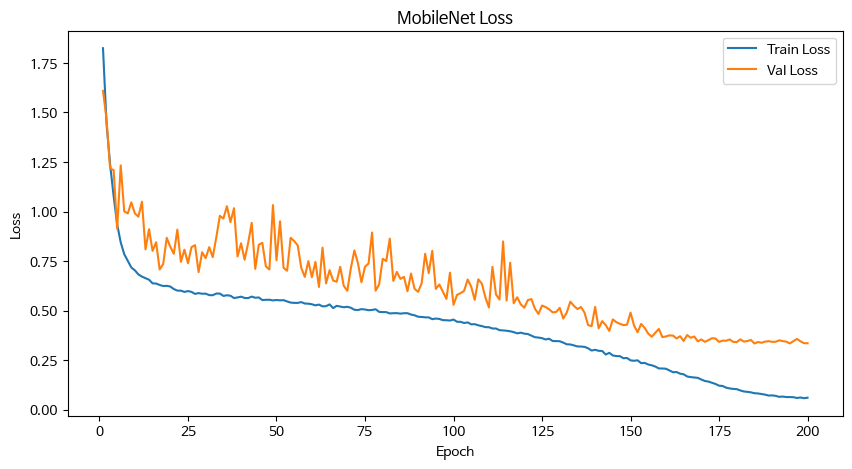

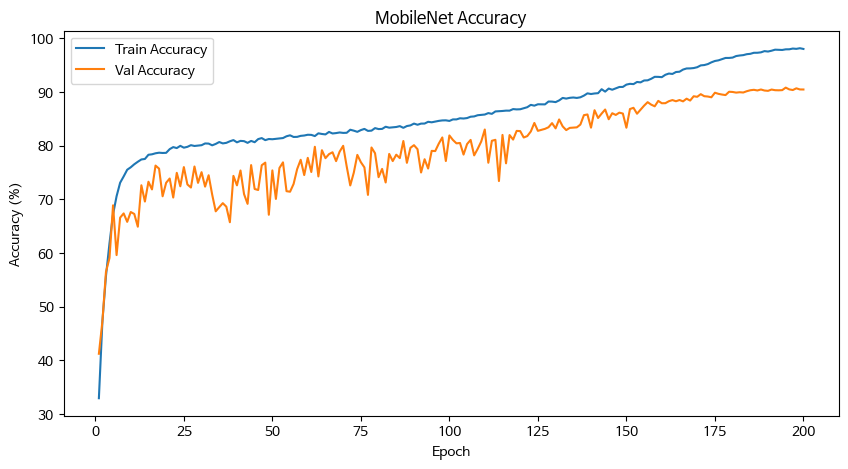

In [ ]:
# Loss graph
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MobileNet Loss')
plt.legend()
plt.show()

# Accuracy graph
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('MobileNet Accuracy')
plt.legend()
plt.show()

In [ ]:
# test
correct = 0
test_loss = 0
model_mobile.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_mobile(images)
        loss = criterion(outputs, labels)

        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        test_loss += loss.item()

test_acc_mobile = 100.* correct / len(test_loader.dataset)
print(f'Test Accuracy: {test_acc_mobile:.2f} %')

test_loss_mobile = test_loss / len(test_loader)
print(f'Test Loss: {test_loss_mobile:.4f}')

Test Accuracy: 90.86 %
Test Loss: 0.3257


In [14]:
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [15]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # 32x32x3 -> 16x16x64
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64,kernel_size=3, padding=1)
        self.bn1_1 = nn.BatchNorm2d(64)

        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn1_2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 16x16x64 -> 8x8x128
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2_1 = nn.BatchNorm2d(128)

        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 8x8x128 -> 4x4x256
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3_1 = nn.BatchNorm2d(256)

        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn3_2 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # flatten
        self.flatten = nn.Flatten()

        # fcl
        self.fc4 = nn.Linear(4 * 4 * 256, 1024)
        self.bn4 = nn.BatchNorm1d(1024)
        self.dropout4 = nn.Dropout(0.2)
        self.fc5 = nn.Linear(1024, 1024)
        self.bn5 = nn.BatchNorm1d(1024)
        self.dropout5 = nn.Dropout(0.2)
        self.fc6 = nn.Linear(1024, 10)

        # relu
        self.relu = nn.ReLU(inplace=True)

        # xavier initialization
        nn.init.xavier_uniform_(self.conv1_1.weight)
        nn.init.xavier_uniform_(self.conv1_2.weight)
        nn.init.xavier_uniform_(self.conv2_1.weight)
        nn.init.xavier_uniform_(self.conv2_2.weight)
        nn.init.xavier_uniform_(self.conv3_1.weight)
        nn.init.xavier_uniform_(self.conv3_2.weight)
        nn.init.xavier_uniform_(self.fc4.weight)
        nn.init.xavier_uniform_(self.fc5.weight)
        nn.init.xavier_uniform_(self.fc6.weight)

    def forward(self, x):
        x = self.relu(self.bn1_1(self.conv1_1(x)))
        x = self.relu(self.bn1_2(self.conv1_2(x)))
        x = self.pool1(x)

        x = self.relu(self.bn2_1(self.conv2_1(x)))
        x = self.relu(self.bn2_2(self.conv2_2(x)))
        x = self.pool2(x)

        x = self.relu(self.bn3_1(self.conv3_1(x)))
        x = self.relu(self.bn3_2(self.conv3_2(x)))
        x = self.pool3(x)

        x = self.flatten(x)

        x = self.relu(self.bn4(self.fc4(x)))
        #x = self.dropout4(x)
        x = self.relu(self.bn5(self.fc5(x)))
        #x = self.dropout5(x)
        x = self.fc6(x)

        return x

In [16]:
model = CNN().to(device)

num_epochs = 200
learning_rate = 0.1
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4) # L2 regularization 적용
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    total = 0
    correct = 0
    train_loss = 0.0

    # train
    model.train()
    print(f'   Epoch [{epoch+1}/{num_epochs}]')
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = 100. * correct / total

    # validation
    model.eval()
    val_loss = 0.0
    val_total = 0
    val_correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100. * val_correct / val_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)


    print(f'Train Loss: {train_loss:.4f}')
    print(f'  Val_Loss: {val_loss:.4f}')
    print(f' Train_acc: {train_accuracy:.2f}%')
    print(f'   Val_acc: {val_accuracy:.2f}%\n')

    scheduler.step()

   Epoch [1/200]
Train Loss: 1.9730
  Val_Loss: 1.5515
 Train_acc: 37.37%
   Val_acc: 43.41%

   Epoch [2/200]
Train Loss: 1.2557
  Val_Loss: 1.5315
 Train_acc: 54.90%
   Val_acc: 51.28%

   Epoch [3/200]
Train Loss: 0.9893
  Val_Loss: 1.0285
 Train_acc: 65.06%
   Val_acc: 64.15%

   Epoch [4/200]
Train Loss: 0.8292
  Val_Loss: 0.8260
 Train_acc: 70.72%
   Val_acc: 70.68%

   Epoch [5/200]
Train Loss: 0.7231
  Val_Loss: 0.9367
 Train_acc: 74.63%
   Val_acc: 68.02%

   Epoch [6/200]
Train Loss: 0.6579
  Val_Loss: 0.8099
 Train_acc: 76.96%
   Val_acc: 72.19%

   Epoch [7/200]
Train Loss: 0.6014
  Val_Loss: 0.6508
 Train_acc: 79.22%
   Val_acc: 77.41%

   Epoch [8/200]
Train Loss: 0.5717
  Val_Loss: 0.7022
 Train_acc: 80.14%
   Val_acc: 75.72%

   Epoch [9/200]
Train Loss: 0.5405
  Val_Loss: 0.8318
 Train_acc: 81.28%
   Val_acc: 72.69%

   Epoch [10/200]
Train Loss: 0.5192
  Val_Loss: 0.6337
 Train_acc: 82.08%
   Val_acc: 78.36%

   Epoch [11/200]
Train Loss: 0.4951
  Val_Loss: 0.9001
 Tr

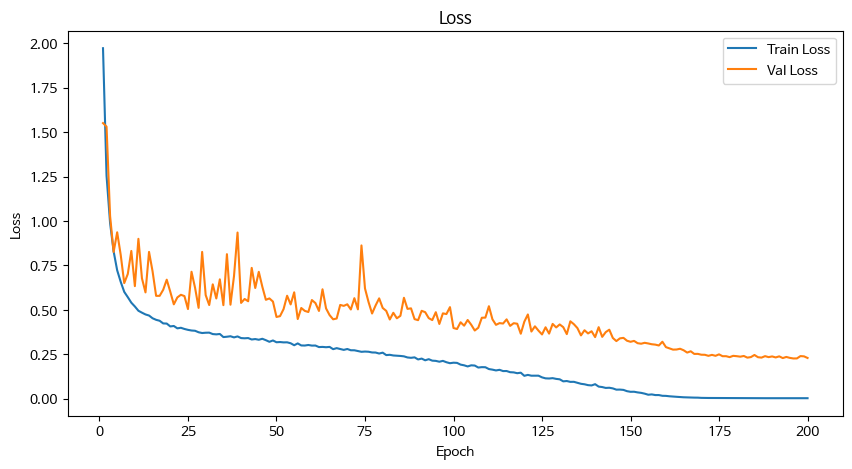

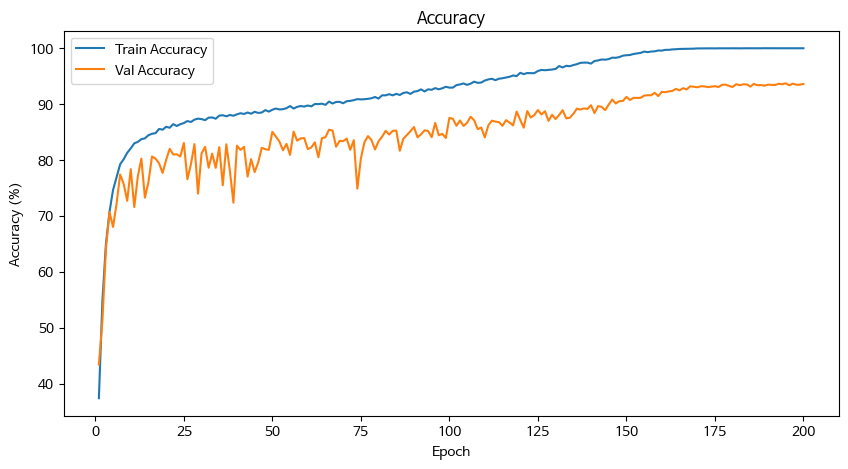

In [ ]:
# Loss graph
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Accuracy graph
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy')
plt.legend()
plt.show()

In [ ]:
# test
correct = 0
test_loss = 0
model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        test_loss += loss.item()

test_acc = 100.* correct / len(test_loader.dataset)
print(f'Test Accuracy: {test_acc:.2f} %')

test_loss = test_loss / len(test_loader)
print(f'Test Loss: {test_loss:.4f}')

Test Accuracy: 93.68 %
Test Loss: 0.2122


In [18]:
# Q1) ResNet18, MobileNet-v1, 본인이 만든 CNN 모델 파라미터 개수 (convolution layer의 weight 개수)비교
# conv layer weight 개수 출력
print('Q1) ResNet18, MobileNet-v1, 본인이 만든 CNN 모델 파라미터 개수 (convolution layer의 weight 개수)')
total_weights_resnet = sum(p.numel() for p in model_resnet.parameters() if p.requires_grad and p.dim() > 1)
total_weights_mobile = sum(p.numel() for p in model_mobile.parameters() if p.requires_grad and p.dim() > 1)
total_weights_custom = sum(p.numel() for p in model.parameters() if p.requires_grad and p.dim() > 1)

print(f"""    Total weights (excluding biases):
    ------------------------------------
    ResNet18 = {total_weights_resnet},
    MobileNet-v1 = {total_weights_mobile},
    Custom CNN Model = {total_weights_custom}
    : ResNet18 > Custom CNN Model > MobileNet-v1
    """)

# Q2) ResNet18, MobileNet-v1, 본인이 만든 CNN 모델의 연산 수 (convolution layer의 곱셈수만 세기) 비교
print('Q2) ResNet18, MobileNet-v1, 본인이 만든 CNN 모델의 연산 수 (convolution layer의 곱셈수만 세기)')
print(f"""
    convolution layer의 곱셈 수 :
    ----------------------------
    ResNet18 Model: 34,697,216
    MobileNet-v1 Model: 14,285,824
    Custom CNN Model: 162,201,600
    : Custom CNN Model > ResNet18 > MobileNet-v1
""")

# Q3) ResNet18, MobileNet-v1, 본인이 만든 CNN 모델의 최종 Test accuracy를 비교 (Test dataset을 이용하여 정확도 측정)
print('Q3) ResNet18, MobileNet-v1, 본인이 만든 CNN 모델 최종 Test accuracy')
print(f"""
    Test Accuracy:
    ----------------------------------------------
    ResNet18 Model Test Accuracy    : {test_acc_resnet:.2f}%
    MobileNet-v1 Model Test Accuracy: {test_acc_mobile:.2f}%
    Custom CNN Model Test Accuracy  : {test_acc:.2f}%
    : ResNet18 > Custom CNN Model > MobileNet-v1
""")

# Q4) 위 3가지 모델 중 어느 모델이 가장 좋다고 할 수 있나요? 이유를 같이 서술하세요
print('Q4) 위 3가지 모델 중 어느 모델이 가장 좋다고 할 수 있나요? 이유를 같이 서술하세요')
print("""
    MobileNet
    ------------------------------------------------------------------------
    가장 효율적인 모델이 좋은 모델이라고 생각한다.
    물론 효율의 기준은 수행해야 할 과제의 특성에 따라 달라진다.
    각 모델이 수행해야 할 과제의 특성이나 환경에 따라 모델의 퍼포먼스는 달라진다.
    MobileNet은 다른 모델에 비해 정확도는 낮지만 모델의 파라티머 개수나 연산 수가
    다른 모델에 비해 확연히 적어 필요로 하는 메모리와 계산 자원이 적기에 필요로
    하는 환경을 쉽게 만족할 수 있다.
""")

Q1) ResNet18, MobileNet-v1, 본인이 만든 CNN 모델 파라미터 개수 (convolution layer의 weight 개수)
    Total weights (excluding biases): 
    ------------------------------------
    ResNet18 = 11164352,
    MobileNet-v1 = 3195328,
    Custom CNN Model = 6397632
    : ResNet18 > Custom CNN Model > MobileNet-v1
    
Q2) ResNet18, MobileNet-v1, 본인이 만든 CNN 모델의 연산 수 (convolution layer의 곱셈수만 세기)

    convolution layer의 곱셈 수 :     
    ----------------------------
    ResNet18 Model: 34,697,216
    MobileNet-v1 Model: 14,285,824
    Custom CNN Model: 162,201,600
    : Custom CNN Model > ResNet18 > MobileNet-v1

Q3) ResNet18, MobileNet-v1, 본인이 만든 CNN 모델 최종 Test accuracy

    Test Accuracy:
    ----------------------------------------------
    ResNet18 Model Test Accuracy    : 94.70%
    MobileNet-v1 Model Test Accuracy: 90.86%
    Custom CNN Model Test Accuracy  : 93.68%
    : ResNet18 > Custom CNN Model > MobileNet-v1

Q4) 위 3가지 모델 중 어느 모델이 가장 좋다고 할 수 있나요? 이유를 같이 서술하세요

    MobileNet
    --------------------